## 0.

In [ ]:
# !nvidia-smi

In [1]:
%%capture
!pip install pytorch-lightning
# !pip install pandas
# !pip install sklearn
# !pip install --upgrade numpy==1.23.1
# !pip install torchmetrics
# !pip install tqdm

In [2]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/MyDrive/Colab Notebooks/code'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/code


In [3]:
import math

import pandas as pd
import numpy as np
import os.path
from IPython.utils import io

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

from project_Prepro import preprocess_XY, preprocess_Y, preprocess_Y2, preprocess_Y_TFM, Split_Interpolate_RNN, Split_Pad_TFM
from project_Data import PhyAAtDataModule



In [4]:
!nvidia-smi

Mon Aug 15 03:05:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.

In [5]:
task_label = {
    1:'Correctness_label',
    2:'SNRdB_label',
    3:'Semanticity_label'
    }

ls = ['S{}'.format(i) for i in range(1,26)]
col = ['Task{}'.format(i) for i in range(1,4)]
result_25 = pd.DataFrame(index = ls, columns = col)
# result_dict = {}

BATCH_SIZE = 1
N_EPOCHS = 100
nhead = 2
d_model = 14

In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000, batch_first = False):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x) :
        """
        shape [ batch_size, seq_len, embedding_dim] when  batch_first = True
        """
        if self.batch_first:
          x = x.permute(1,0,2)
          x = x + self.pe[0, :x.size(0)]
          x = x.permute(1,0,2)
        else:
          x = x + self.pe[0, :x.size(0)]

        # x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [7]:
class Transformer(nn.Module):

    def __init__(self, 
                 d_model: int, # input feature dimension
                 seq_len: int,
                 n_class: int, # number of output class label
                 nhead: int, 
                 d_hid: int,
                 nlayers: int, 
                 dropout: float):
        
        super().__init__()
        self.nhead = nhead
        self.pos_emb = PositionalEncoding(d_model, dropout, batch_first = True)
        
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first = True)
        self.encoder = TransformerEncoder(encoder_layers, nlayers)
        self.fl = nn.Flatten()
        self.classifier = nn.Linear(seq_len*d_model, n_class)
    

        self.init_weights()


    def init_weights(self):
        initrange = 0.1
        
        self.classifier.bias.data.zero_()
        self.classifier.weight.data.uniform_(-initrange, initrange)
        
    def get_self_pad_mask(self, batch_q, batch_k, nhead):
        batch_size, len_q, _ = batch_q.size()
        batch_size, len_k, _ = batch_k.size()
        all_seq = batch_k[:,:,0]
        batch_pad_mask = []
        for i in range(all_seq.shape[0]):
            seq_pad_mask = all_seq[i].data.eq(0).unsqueeze(0)  #1 x len_k(=len_q), one is masking
            seq_pad_mask = seq_pad_mask.expand(len_q, len_k)
            batch_pad_mask.append(seq_pad_mask)
        # batch_pad_mask = torch.stack(batch_pad_mask,0).repeat(nhead, 1, 1)
        batch_pad_mask = torch.stack(batch_pad_mask,0)
        return  batch_pad_mask  # batch_size * nhead x len_q x len_k
    

    def forward(self, src):
        # pad_mask = self.get_self_pad_mask(src,src,self.nhead)
        # pad_mask = torch.rand(src.shape[0],src.shape[1],src.shape[1])>0

        src = self.pos_emb(src) 

        # print(src.shape,pad_mask.shape)
        output = self.encoder(src)

        output = self.fl(output)
        output_logit = self.classifier(output)

        return output_logit

In [8]:
class TransformerModel(pl.LightningModule):
    def __init__(self, d_model, seq_len,n_class, nhead, d_hid, nlayers, dropout):
        super().__init__()
        self.model = Transformer(d_model, seq_len, n_class, nhead, d_hid, nlayers, dropout)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x, labels = None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        # print('train process begin:')
        sequences = batch['feature']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)
        
        self.log('train_loss', loss, prog_bar=True, logger=True)
        self.log('train_accuracy', step_accuracy, prog_bar=True, logger=True)
        return {'loss':loss, 'accuracy': step_accuracy}

    def validation_step(self, batch, batch_idx):
        # print('val process begin:')
        sequences = batch['feature']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)
        
        self.log('val_loss', loss, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_accuracy',  step_accuracy, prog_bar=True, logger=True, sync_dist=True)
        return {'loss':loss, 'accuracy': step_accuracy}
        
    def test_step(self, batch, batch_idx):
        # print('test process begin:')
        sequences = batch['feature']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)
        
        self.log('test_loss', loss, prog_bar=True, logger=True)
        self.log('test_accuracy', step_accuracy, prog_bar=True, logger=True)
        return {'loss':loss, 'accuracy': step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = 0.001 , weight_decay =0)

In [ ]:
result_25 = pd.read_csv("result_TFM.csv", index_col = 0)
result_25

,Task1,Task2,Task3
S1,0.60,0.55,0.55
S2,0.55,0.55,0.57
S3,0.60,0.60,0.60
S4,0.57,0.57,0.57
S5,0.52,0.52,0.50
S6,0.52,0.55,0.57
S7,0.64,0.52,0.55
S8,0.55,0.57,0.57
S9,0.64,0.52,0.52
S10,0.50,0.55,0.57


In [ ]:
class PhyAAtDataset(Dataset):
    
    def __init__(self, X_trial):
        self.X_trial = X_trial
        
    def __len__(self):
        return len(self.X_trial)
    
    # def shape(self):
    #     if self.X_trial[0][0].shape != self.X_trial[1][0].shape:
    #         assert 'different shape'
    #     return len(self.X_trial), self.X_trial[0][0].shape[0], self.X_trial[0][0].shape[1]
    
    def __getitem__(self, idx):
        feature,label = self.X_trial[idx]
        
        # feature = torch.tensor(feature).clone().detach()

        # feature = feature
        # feature = feature.float()
        feature = feature.float()
        # label = torch.tensor(label).long()
        label = label.long()
        return dict(
            feature = feature,
            label = label
        )

class PhyAAtDataModule(pl.LightningDataModule):
    
    def __init__(self, train_sequences, valid_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.valid_sequences = valid_sequences
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.train_dataset = PhyAAtDataset(self.train_sequences)
        self.valid_dataset = PhyAAtDataset(self.valid_sequences)
        self.test_dataset = PhyAAtDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = True  
            ,num_workers = 4
            ,persistent_workers=True
        )
    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size = self.batch_size,
            shuffle = False
            ,num_workers = 4
            ,persistent_workers=True
        )
    def test_dataloader(self): 
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False
            ,num_workers = 4
            ,persistent_workers=True
        )


## 2.Train

In [11]:
for subject_No in range(25,26):
    print("Subject No." + str(subject_No) + ":")
    path = 'X{}_trial.csv'.format(subject_No)
    Y = pd.read_csv('S{0}_Textscore.csv'.format(subject_No))
    # 1  data process
    if os.path.exists(path):
      X = pd.read_csv(path)
      Y = preprocess_Y_TFM(subject_No)
    else:
      X, Y = preprocess_XY(subject_No)
      X.to_csv('X{}_trial.csv'.format(subject_No),index = False)

    FEATURE_COLUMNS = X.columns[1:15].tolist()
    
    ls = ['S{}'.format(subject_No)]
    col = ['Task{}'.format(i) for i in range(1,4)]
    result_indi = pd.DataFrame(index = ls, columns = col)
    
    for target_task in range(1,4):
        print("Task:",target_task)
        target_label = task_label[target_task]

        # 2 split
        X_trial, max_trial_length = Split_Pad_TFM(X, Y, target_label)
        
        train_sequences, test_sequences = train_test_split(X_trial, test_size = 0.25)
        valid_sequences, test_sequences = train_test_split(test_sequences, test_size = 0.4)

        # 3 Dataset DataModuel
        data_module = PhyAAtDataModule(train_sequences, valid_sequences, test_sequences, BATCH_SIZE)


        # 4 Net and Model
        model = TransformerModel(
            d_model = len(FEATURE_COLUMNS),
            seq_len = max_trial_length,
            nhead = nhead,
            n_class = len(Y[task_label[target_task]].unique()),
            d_hid = 2048,
            nlayers = 6, 
            dropout = 0.5
        )
        
        # 5 Train
        earlystopping_callback = EarlyStopping(
            monitor = 'val_accuracy',
            mode = 'max',
            patience = 10
        )

        checkpoint_callback = ModelCheckpoint(
            # dirpath = 'lightning_logs/checkpoints',
            # filename = '{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}' ,
            filename = '{val_accuracy:.2f}',
            save_top_k = 1,
            verbose = True,
            monitor = 'val_accuracy',
            mode = "max"
        )


        # callback_list = [earlystopping_callback]
        callback_list = [checkpoint_callback, earlystopping_callback]
        # logger = TensorBoardLogger("lightning_logs", name = task_label[target_task])
        # logger = TensorBoardLogger("lightning_logs", name = "Correctness")

        trainer = pl.Trainer(
        #     logger=logger,
            callbacks=callback_list,
            max_epochs=N_EPOCHS
            ,accelerator='gpu', 
            devices=1
            # ,auto_lr_find=True
        )
        
     
        trainer.fit(model, data_module)
        
        # 6 test and result
        test_result = trainer.test(model, dataloaders = data_module.test_dataloader())
        best_model_score = round(test_result[0]['test_accuracy'],2)
        result_25.at["S{}".format(subject_No), "Task{}".format(target_task)] = best_model_score
        result_indi.at["S{}".format(subject_No), "Task{}".format(target_task)] = best_model_score
        # result.at["S{}".format(subject_No), "Task{}".format(target_task)] = round(float(checkpoint_callback.best_model_score),2)
    result_indi.to_csv('result_TFM_S{}.csv'.format(subject_No), index = False)
        # print(result)

Subject No.25:
Task: 1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Transformer      | 1.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.039     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 108: 'val_accuracy' reached 0.52381 (best 0.52381), saving model to '/content/gdrive/MyDrive/Colab Notebooks/code/lightning_logs/version_72/checkpoints/val_accuracy=0.52.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 216: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 324: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 432: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 540: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 648: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 756: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 864: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 972: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 1080: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 1188: 'val_accuracy' was not in top 1
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4000000059604645
        test_loss            21.2242431640625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Task: 2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Transformer      | 750 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
750 K     Trainable params
0         Non-trainable params
750 K     Total params
3.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 108: 'val_accuracy' reached 0.52381 (best 0.52381), saving model to '/content/gdrive/MyDrive/Colab Notebooks/code/lightning_logs/version_73/checkpoints/val_accuracy=0.52.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 216: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 324: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 432: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 540: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 648: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 756: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 864: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 972: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 1080: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 1188: 'val_accuracy' was not in top 1
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.46666666865348816
        test_loss           0.8865569829940796
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Task: 3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Transformer      | 491 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
491 K     Trainable params
0         Non-trainable params
491 K     Total params
1.966     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 108: 'val_accuracy' reached 0.61905 (best 0.61905), saving model to '/content/gdrive/MyDrive/Colab Notebooks/code/lightning_logs/version_74/checkpoints/val_accuracy=0.62.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 216: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 324: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 432: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 540: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 648: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 756: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 864: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 972: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 1080: 'val_accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 1188: 'val_accuracy' was not in top 1
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6000000238418579
        test_loss            4.762319087982178
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [12]:
result_25

,Task1,Task2,Task3
S1,0.4,0.6,0.33
S2,0.47,0.67,0.6
S3,0.6,0.47,0.53
S4,0.53,0.27,0.53
S5,0.53,0.53,0.53
S6,0.47,0.6,0.47
S7,0.47,0.47,0.53
S8,0.53,0.67,0.47
S9,0.47,0.4,0.6
S10,0.67,0.53,0.53


In [13]:
result = result_25

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dd37c6510>,
      dtype=object)

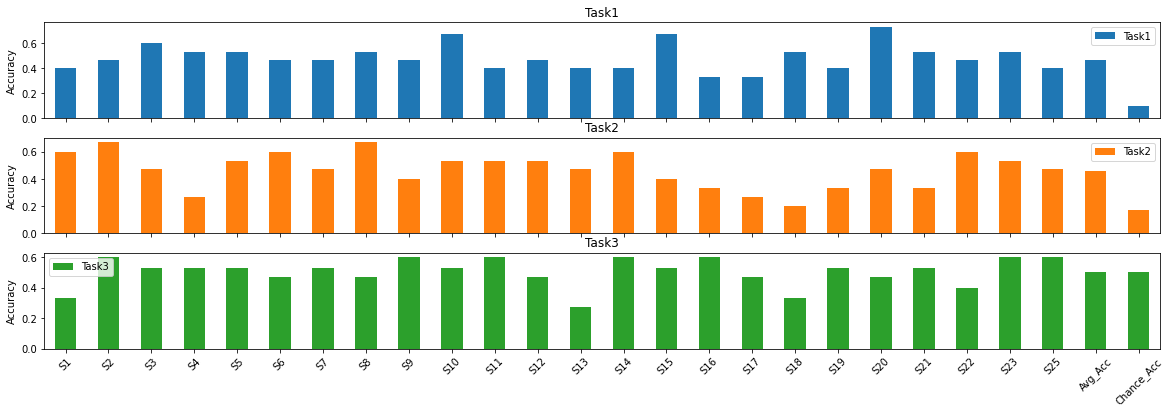

In [15]:
result.at['Avg_Acc'] = round(result.mean(axis = 0, skipna = True),2)
chance_acc = [0.1, 0.17, 0.5]
result.at['Chance_Acc'] = chance_acc
result = result.drop(index = 'S24')
result_25.to_csv('result_TFM_24.csv')
result.plot.bar(subplots = True, figsize = (20, 6), ylabel = 'Accuracy', rot = 45)


In [16]:
result

,Task1,Task2,Task3
S1,0.4,0.6,0.33
S2,0.47,0.67,0.6
S3,0.6,0.47,0.53
S4,0.53,0.27,0.53
S5,0.53,0.53,0.53
S6,0.47,0.6,0.47
S7,0.47,0.47,0.53
S8,0.53,0.67,0.47
S9,0.47,0.4,0.6
S10,0.67,0.53,0.53
